# Example GSE123139 co-expression

### Dataset
This is an demonstration of co-expression analysis with Normalisr within dysfunctional T cells in human melanoma scRNA-seq. This includes iterative removal of top GO pathways. Only a subset of cells were extracted from GSE123139 dataset for this demonstration. You can change it to all the cells by following the guideline in example README.

**Warning**: You will only get the actual results with the **full dataset** of all cells. This example is intended as a demonstration of use for Normalisr, than an exact reproduction of our results in the manuscript.

### Usage
You can get the help of any function by typing ?func in jupyter notebook. For example, the line below shows documentation for function 'open'.

`?open`

To get help for Normalisr, try a specific function such as

`import normalisr as norm
?norm.coex.coex`

In [1]:
import numpy as np
import normalisr as norm
from os.path import join as pjoin
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

diri='../data/coex'

### Optional extra logging

In [ ]:
import logging
logging.basicConfig(level=logging.DEBUG)

### Load data

In [2]:
dt0=np.loadtxt(pjoin(diri,'0_read.tsv.gz'),delimiter='\t',dtype=int)
dc=np.loadtxt(pjoin(diri,'0_cov.tsv.gz'),delimiter='\t',dtype=int)
with open(pjoin(diri,'0_gene.txt'),'r') as f:
	namet=np.array([x.strip() for x in f.readlines()])
with open(pjoin(diri,'0_cell.txt'),'r') as f:
	names=np.array([x.strip() for x in f.readlines()])
with open(pjoin(diri,'0_cov.txt'),'r') as f:
	namec=np.array([x.strip() for x in f.readlines()])
nc,ns,nt=[len(x) for x in [namec,names,namet]]
assert dt0.shape==(nt,ns) and dc.shape==(nc,ns)

### Initial QC for low read cell and gene removal

In [3]:
select=norm.qc.qc_reads(dt0,0,500,0.02,500,100,0)
print('Genes passed QC: {}/{}'.format(len(select[0]),nt))
print('Cells passed QC: {}/{}'.format(len(select[1]),ns))

dt0=dt0[select[0]][:,select[1]].copy()
dc=dc[:,select[1]].copy()
namet=namet[select[0]]
names=names[select[1]]
ns,nt=[len(x) for x in [names,namet]]
assert dt0.shape==(nt,ns) and dc.shape==(nc,ns)

Genes passed QC: 1582/27929
Cells passed QC: 5078/5098


### Compute Bayesian logCPM and cellular summary covariates

In [4]:
dt,_,_,dc2=norm.lcpm.lcpm(dt0)
dc=np.concatenate([dc,dc2],axis=0)

### Normalize covariates and add constant-1 covariate

In [5]:
dc=norm.norm.normcov(dc)

### Compute variance normalization factors for each gene and each cell

In [6]:
sf=norm.lcpm.scaling_factor(dt0)
weight=norm.norm.compute_var(dt,dc)

### Detect very-low-variance cell outliers

In [7]:
select=norm.qc.qc_outlier(weight)

### Remove very-low-variance cell outliers

In [8]:
print('Cells passed outlier QC: {}/{}'.format(select.sum(),ns))
dt0=dt0[:,select].copy()
dt=dt[:,select].copy()
dc=dc[:,select].copy()
weight=weight[select]
names=names[select]
ns=len(names)

Cells passed outlier QC: 5064/5078


### Normalize gene expression at mean and variance levels and covariates at variance level

In [9]:
dt,dc=norm.norm.normvar(dt,dc,weight,sf)

### Compute co-expression network from 0 to 5 removals of top GO pathways

In [10]:
#Maximum number of iterations of GO pathway removal
lvmax=5
#Q-value cutoff when binarizing network
qcut=1E-8
#GO DAG file, downloadable from http://geneontology.org/docs/download-ontology/
go_file='../data/go/go-basic.obo'
#GO annotation file, downloadable from http://current.geneontology.org/products/pages/downloads.html
goa_file='../data/go/goa-human.gaf'
#Gene name conversion rule from your gene ID system to GO annotation file's ID system
#Format: (Your ID system, GO annotation file's ID system, species)
#Names of gene ID systems can be found at https://docs.mygene.info/en/latest/doc/data.html
conversion=("symbol,alias","uniprot.Swiss-Prot","human")

dc2=dc.copy()
coex=[]
for xi in range(lvmax+1):
	#Compute co-expression network of P-values and Pearson R
	coex1=norm.coex.coex(dt,dc2)
	#Binarize co-expression network
	coex2=norm.binnet.binnet(coex1[0],qcut)
	#Get strongest GO pathway 
	go=norm.gocovt.gotop(coex2,namet,go_file,goa_file,conversion=conversion)
	#Store this iteration of results
	coex.append((coex1,coex2,go,dc2))
	#Prepare GO covariate for next iteration
	dc2=norm.gocovt.pccovt(dt,dc2,namet,go[3])


querying 1-1000...done.
querying 1001-1582...done.
Finished.
216 input query terms found dup hits:
	[('EEF1DP1', 3), ('SNORD54', 2), ('RPL9P3', 2), ('CFL1', 2), ('RPS2P7', 2), ('PFN1P1', 2), ('TRGC2',
134 input query terms found no hit:
	['RP11-75L1.2', 'RP5-857K21.7', 'ERCC-00046', 'RP11-1035H13.3', 'RP3-417G15.1', 'RP5-1106E3.1', 'RP1
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
../data/go/go-basic.obo: fmt(1.2) rel(2020-05-02) 47,240 GO Terms
  READ      505,463 associations: ../data/go/goa-human.gaf
fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


 98%  1,282 of  1,304 population items found in association
 99%     66 of     67 study items found in association
Calculating 8,344 uncorrected p-values using fisher_scipy_stats
   8,344 GO terms are associated with  1,282 of  1,304 population items
   2,031 GO terms are associated with     66 of     67 study items
      11 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
      11 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
      11 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8344 items WROTE: /tmp/tmp55qe4pyc
querying 1-1000...done.
querying 1001-1582...done.
Finished.
216 input query terms found dup hits:
	[('EEF1DP1', 3), ('SNORD54', 2), ('RPL9P3', 2), ('CFL1', 2), ('RPS2P7', 2), ('PFN1P1', 2), ('TRGC2',
134 input query terms found no hit:
	['RP11-75L1.2', 'RP5-857K21.7', 'ERCC-00046', 'RP11-1035H13.3', 'RP3-417G15.1', 'RP5-1106E3.1', 'RP1
Pass "returnall=True" to ret

Propagating term counts to parents ..


 98%  1,282 of  1,304 population items found in association
 99%     78 of     79 study items found in association
Calculating 8,344 uncorrected p-values using fisher_scipy_stats
   8,344 GO terms are associated with  1,282 of  1,304 population items
   2,590 GO terms are associated with     78 of     79 study items
      21 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
      21 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
      21 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8344 items WROTE: /tmp/tmpsf9oh4rg
querying 1-1000...done.
querying 1001-1582...done.
Finished.
216 input query terms found dup hits:
	[('EEF1DP1', 3), ('SNORD54', 2), ('RPL9P3', 2), ('CFL1', 2), ('RPS2P7', 2), ('PFN1P1', 2), ('TRGC2',
134 input query terms found no hit:
	['RP11-75L1.2', 'RP5-857K21.7', 'ERCC-00046', 'RP11-1035H13.3', 'RP3-417G15.1', 'RP5-1106E3.1', 'RP1
Pass "returnall=True" to ret

Propagating term counts to parents ..


 98%  1,282 of  1,304 population items found in association
 99%     79 of     80 study items found in association
Calculating 8,344 uncorrected p-values using fisher_scipy_stats
   8,344 GO terms are associated with  1,282 of  1,304 population items
   2,613 GO terms are associated with     79 of     80 study items
      18 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
      18 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
      18 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8344 items WROTE: /tmp/tmpv28t9jst
querying 1-1000...done.
querying 1001-1582...done.
Finished.
216 input query terms found dup hits:
	[('EEF1DP1', 3), ('SNORD54', 2), ('RPL9P3', 2), ('CFL1', 2), ('RPS2P7', 2), ('PFN1P1', 2), ('TRGC2',
134 input query terms found no hit:
	['RP11-75L1.2', 'RP5-857K21.7', 'ERCC-00046', 'RP11-1035H13.3', 'RP3-417G15.1', 'RP5-1106E3.1', 'RP1
Pass "returnall=True" to ret

Propagating term counts to parents ..


 98%  1,282 of  1,304 population items found in association
 99%     78 of     79 study items found in association
Calculating 8,344 uncorrected p-values using fisher_scipy_stats
   8,344 GO terms are associated with  1,282 of  1,304 population items
   2,612 GO terms are associated with     78 of     79 study items
      18 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
      18 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
      18 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8344 items WROTE: /tmp/tmpv9x5vd8g
querying 1-1000...done.
querying 1001-1582...done.
Finished.
216 input query terms found dup hits:
	[('EEF1DP1', 3), ('SNORD54', 2), ('RPL9P3', 2), ('CFL1', 2), ('RPS2P7', 2), ('PFN1P1', 2), ('TRGC2',
134 input query terms found no hit:
	['RP11-75L1.2', 'RP5-857K21.7', 'ERCC-00046', 'RP11-1035H13.3', 'RP3-417G15.1', 'RP5-1106E3.1', 'RP1
Pass "returnall=True" to ret

Propagating term counts to parents ..


 98%  1,282 of  1,304 population items found in association
 99%     81 of     82 study items found in association
Calculating 8,344 uncorrected p-values using fisher_scipy_stats
   8,344 GO terms are associated with  1,282 of  1,304 population items
   2,638 GO terms are associated with     81 of     82 study items
      20 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
      20 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
      20 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8344 items WROTE: /tmp/tmpyw_sf_iw
querying 1-1000...done.
querying 1001-1582...done.
Finished.
216 input query terms found dup hits:
	[('EEF1DP1', 3), ('SNORD54', 2), ('RPL9P3', 2), ('CFL1', 2), ('RPS2P7', 2), ('PFN1P1', 2), ('TRGC2',
134 input query terms found no hit:
	['RP11-75L1.2', 'RP5-857K21.7', 'ERCC-00046', 'RP11-1035H13.3', 'RP3-417G15.1', 'RP5-1106E3.1', 'RP1
Pass "returnall=True" to ret

Propagating term counts to parents ..


 98%  1,282 of  1,304 population items found in association
 99%     79 of     80 study items found in association
Calculating 8,344 uncorrected p-values using fisher_scipy_stats
   8,344 GO terms are associated with  1,282 of  1,304 population items
   2,586 GO terms are associated with     79 of     80 study items
      27 GO terms found significant (< 0.05=alpha) after multitest correction: local bonferroni
      28 GO terms found significant (< 0.05=alpha) after multitest correction: local sidak
      27 GO terms found significant (< 0.05=alpha) after multitest correction: local holm
   8344 items WROTE: /tmp/tmpyf7_8gmg


## Visalization
### Top GOs without removal through GO covariate

In [11]:
coex[0][2][1].head(3)

name  depth  p_uncorrected  p_bonferroni  \
6189                   ribosomal subunit      3   1.545957e-12  1.289947e-08   
7056        structural molecule activity      1   2.532997e-10  2.113533e-06   
7057  structural constituent of ribosome      2   6.113680e-10  5.101255e-06   

      odds_ratio ratio_in_study ratio_in_pop          GO  \
6189    5.266374          23/67      85/1304  GO:0044391   
7056    4.927262          20/67      79/1304  GO:0005198   
7057    5.704581          17/67      58/1304  GO:0003735   

                                            study_items  
6189  RPLP2,RPS2,RPS12,RPL13,RPS19,RPL27A,RPL34,RPS2...  
7056  RPLP2,TUBB,RPS2,RPS12,RPS19,RPL27A,ACTB,RPS20,...  
7057  RPLP2,RPS2,RPS12,RPS19,RPL27A,RPS20,RPL26,RPS1...

### Top GOs after 1 removal through GO covariate

In [12]:
coex[1][2][1].head(3)

name  depth  p_uncorrected  p_bonferroni  \
7056   receptor regulator activity      2   9.078075e-11  7.574746e-07   
7057  receptor antagonist activity      4   1.762664e-08  1.470767e-04   
0                 defense response      3   4.002865e-08  3.339991e-04   

      odds_ratio ratio_in_study ratio_in_pop          GO  \
7056    9.903797          12/79      20/1304  GO:0030545   
7057   14.443038           7/79       8/1304  GO:0048019   
0       4.454089          17/79      63/1304  GO:0006952   

                                            study_items  
7056  IFNG,HMGB1,MTRNR2L1,MTRNR2L2,MTRNR2L6,MTRNR2L8...  
7057  MTRNR2L1,MTRNR2L2,MTRNR2L6,MTRNR2L8,MTRNR2L9,M...  
0     IFNG,HLA-DRB1,GAPDH,HLA-A,ISG15,HMGB1,IFI6,GZM...

### Top GOs after 2 removals through GO covariate

In [13]:
coex[2][2][1].head(3)

name  depth  p_uncorrected  p_bonferroni  \
7056   receptor regulator activity      2   1.061612e-10  8.858092e-07   
7057  receptor antagonist activity      4   1.930317e-08  1.610656e-04   
0                 defense response      3   4.904696e-08  4.092478e-04   

      odds_ratio ratio_in_study ratio_in_pop          GO  \
7056    9.780000          12/80      20/1304  GO:0030545   
7057   14.262500           7/80       8/1304  GO:0048019   
0       4.398413          17/80      63/1304  GO:0006952   

                                            study_items  
7056  IFNG,HMGB1,MTRNR2L1,MTRNR2L2,MTRNR2L6,MTRNR2L8...  
7057  MTRNR2L1,MTRNR2L2,MTRNR2L6,MTRNR2L8,MTRNR2L9,M...  
0     IFNG,HLA-DRB1,GAPDH,HLA-A,ISG15,HMGB1,IFI6,GZM...

### Networks

Co-expression with 0 GO covariates removed.
Number of nodes in full network: 503
Number of edges in full network: 1534
Number of nodes in major connected component: 414
Number of edges in major connected component: 1446


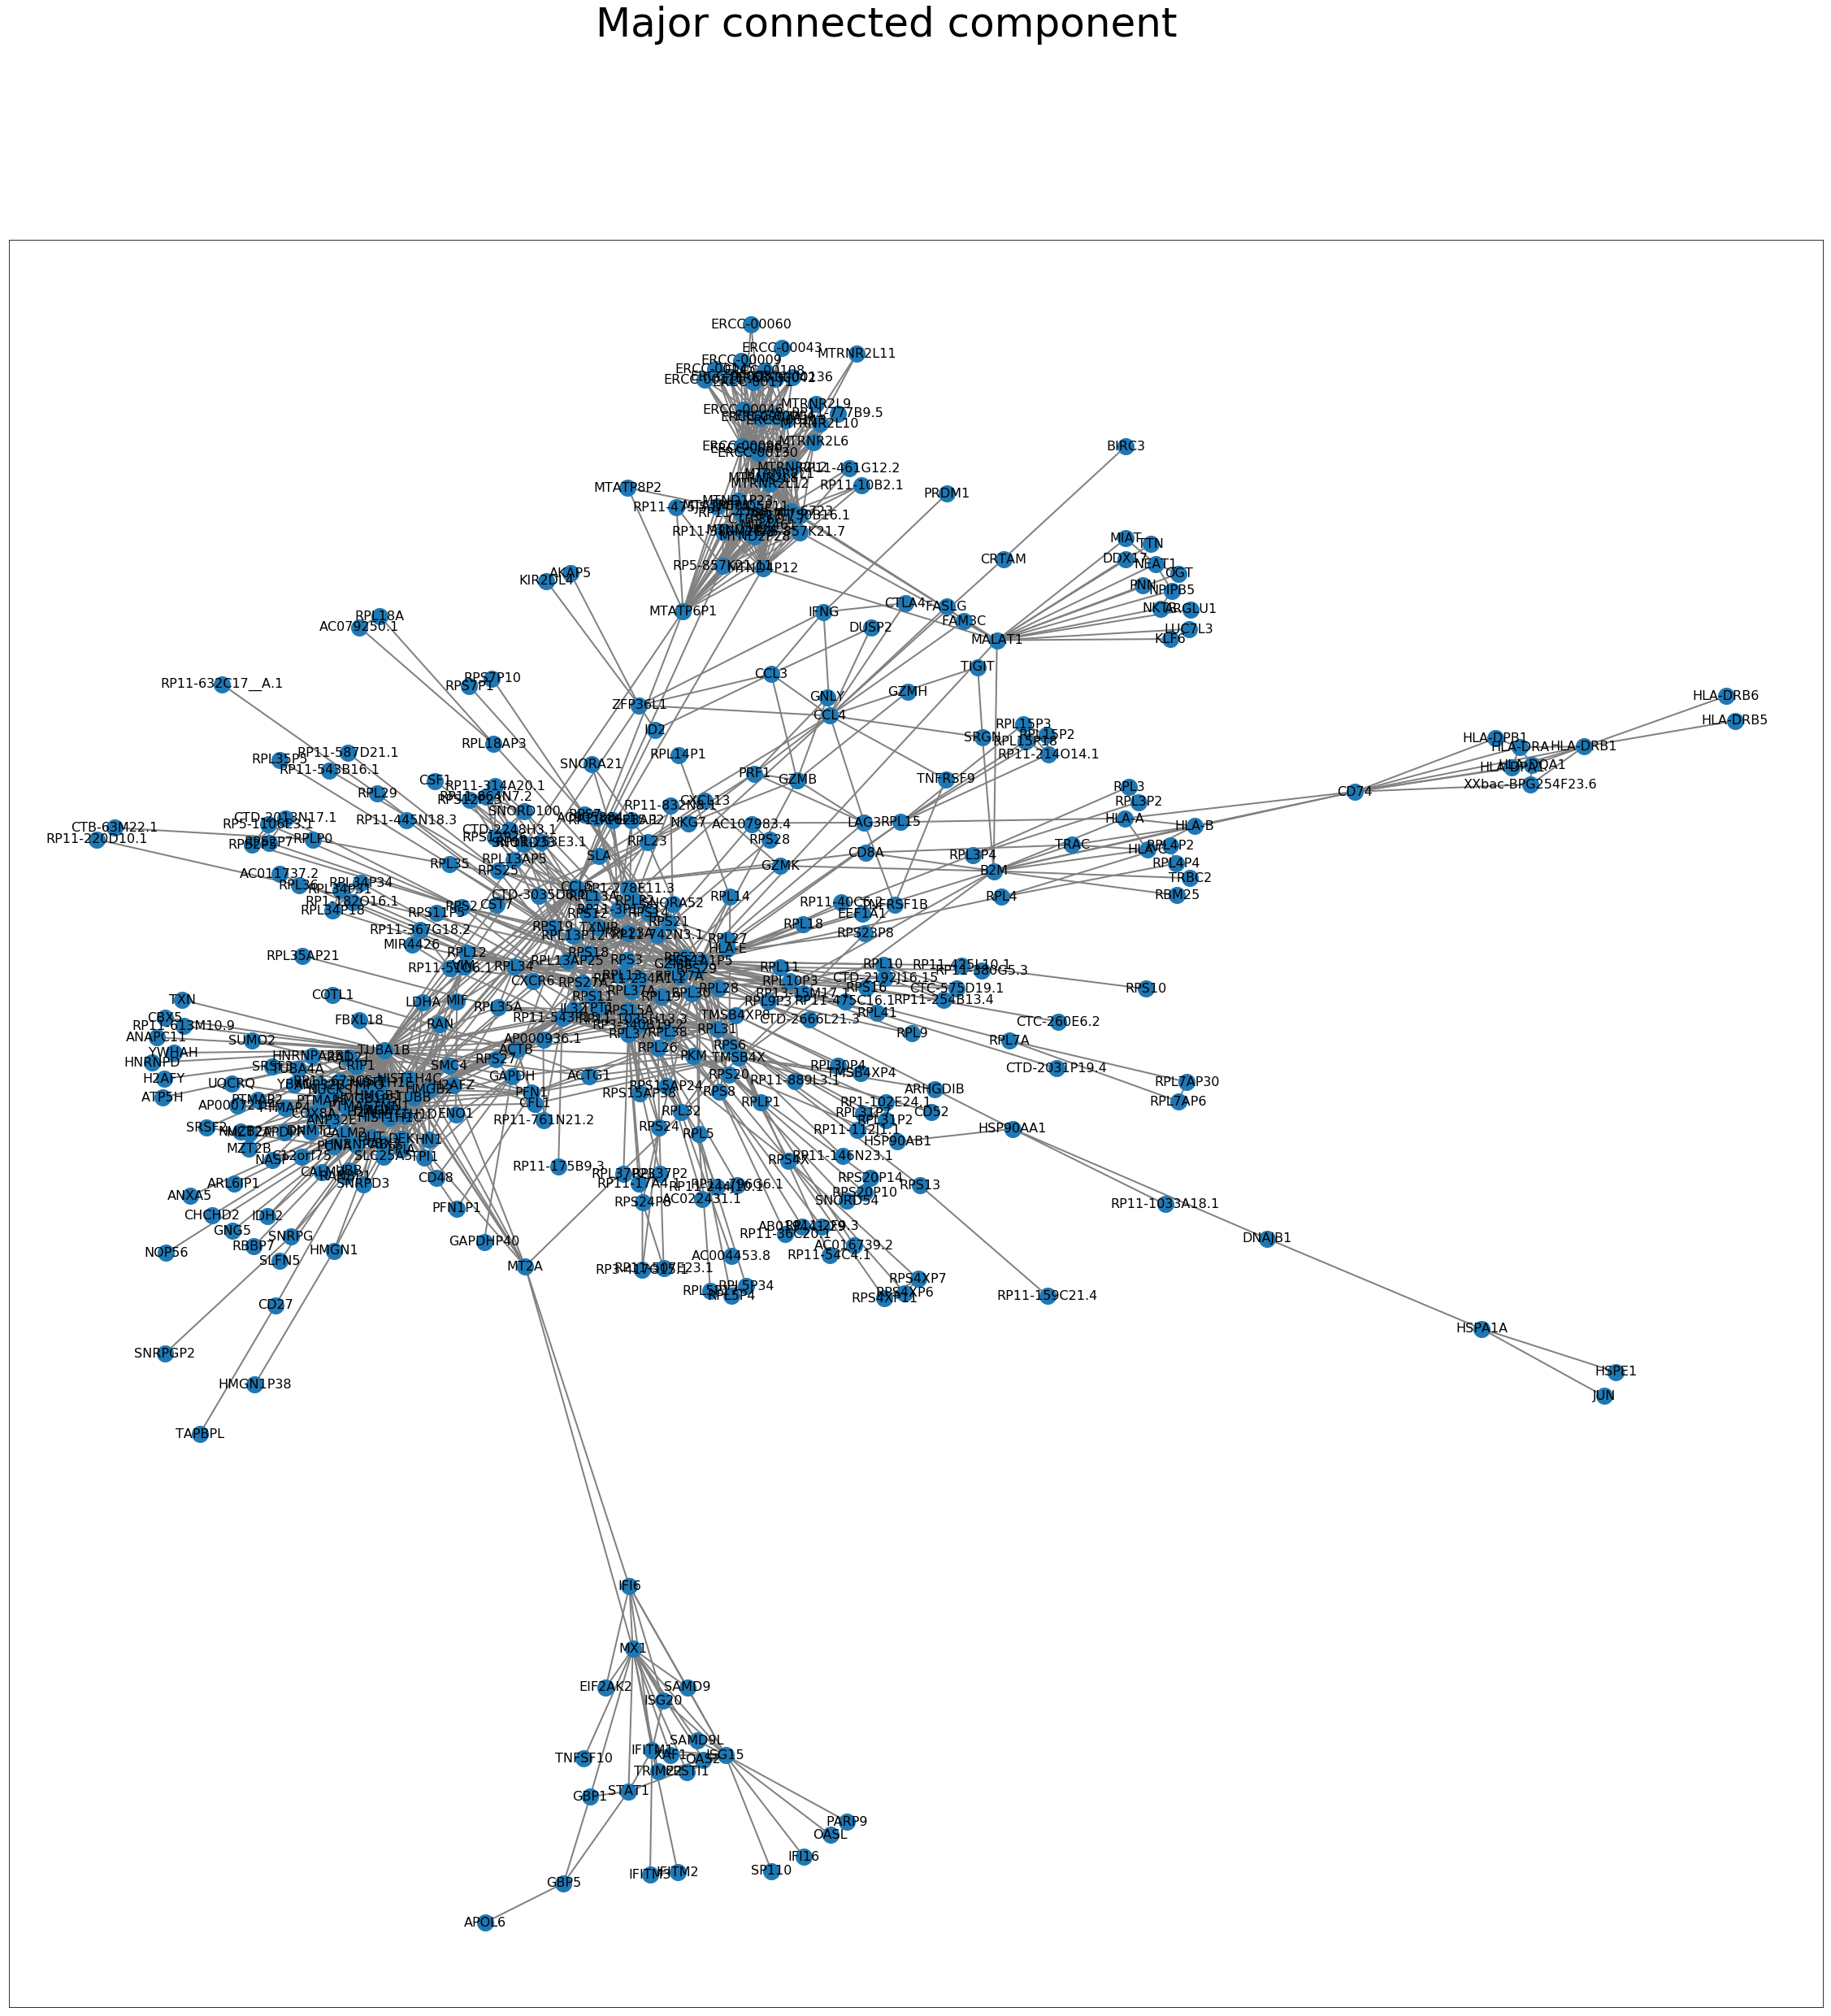

Co-expression with 1 GO covariates removed.
Number of nodes in full network: 486
Number of edges in full network: 1118
Number of nodes in major connected component: 233
Number of edges in major connected component: 827


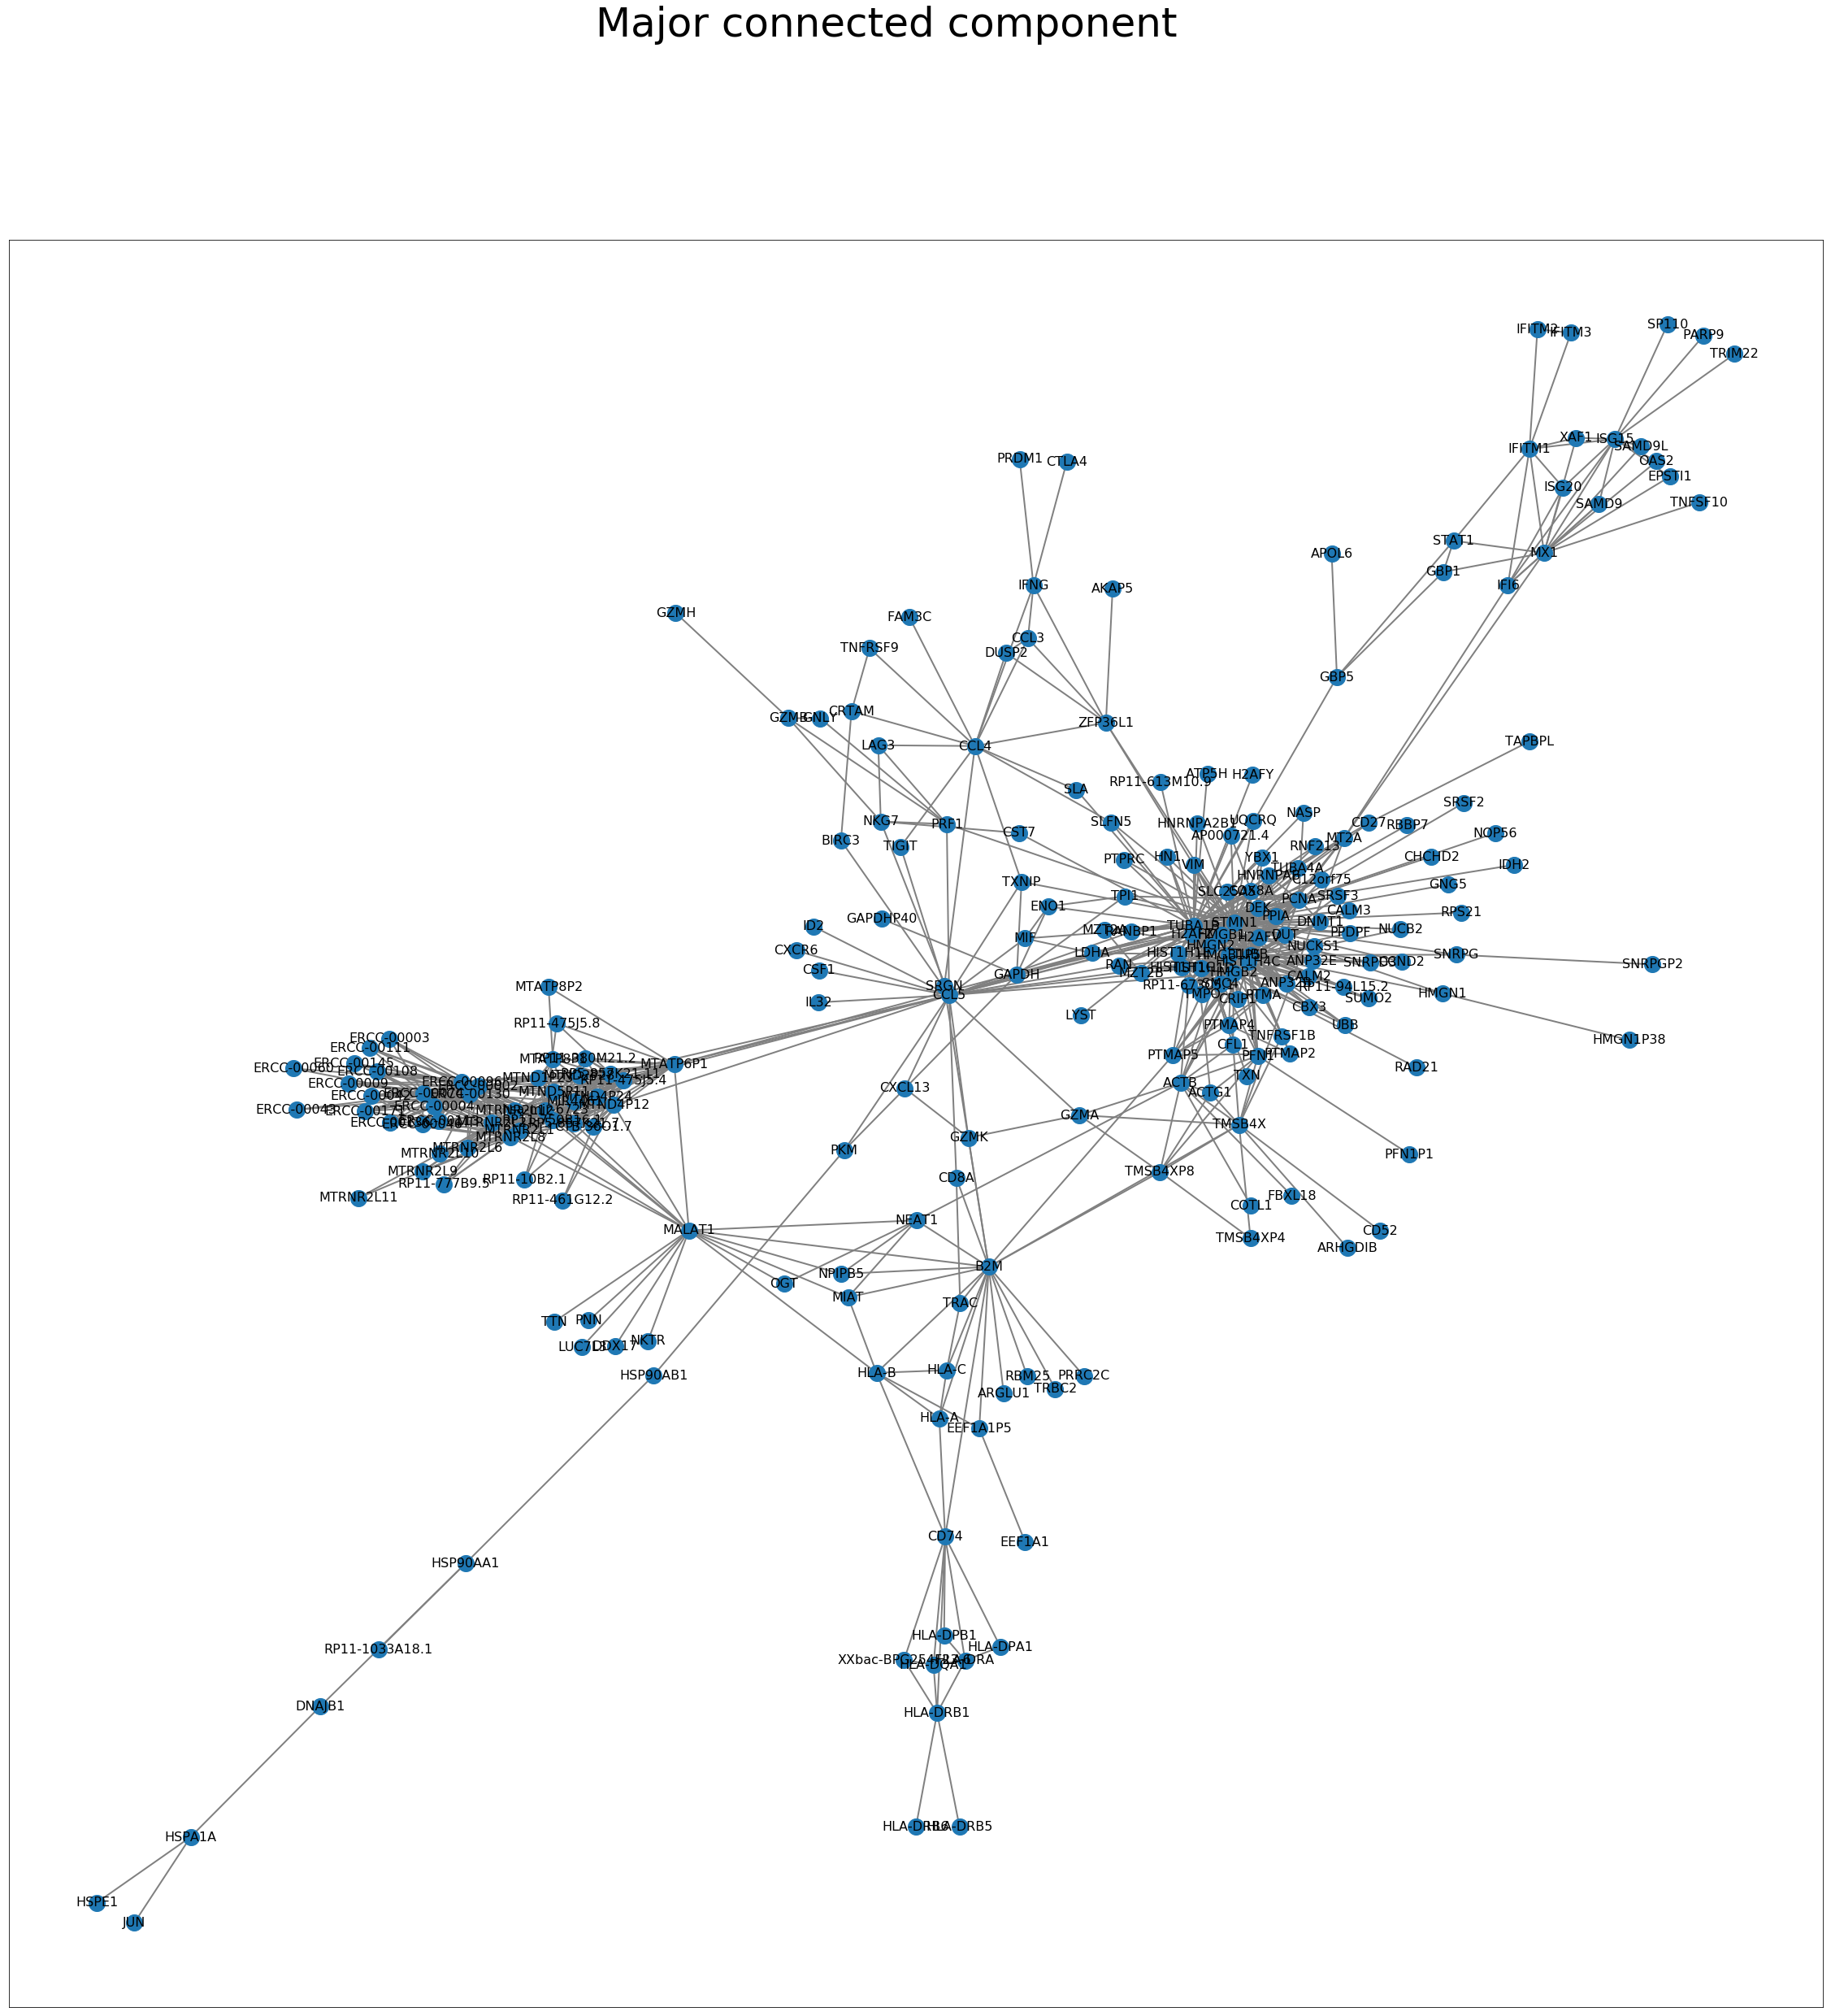

Co-expression with 2 GO covariates removed.
Number of nodes in full network: 482
Number of edges in full network: 989
Number of nodes in major connected component: 221
Number of edges in major connected component: 677


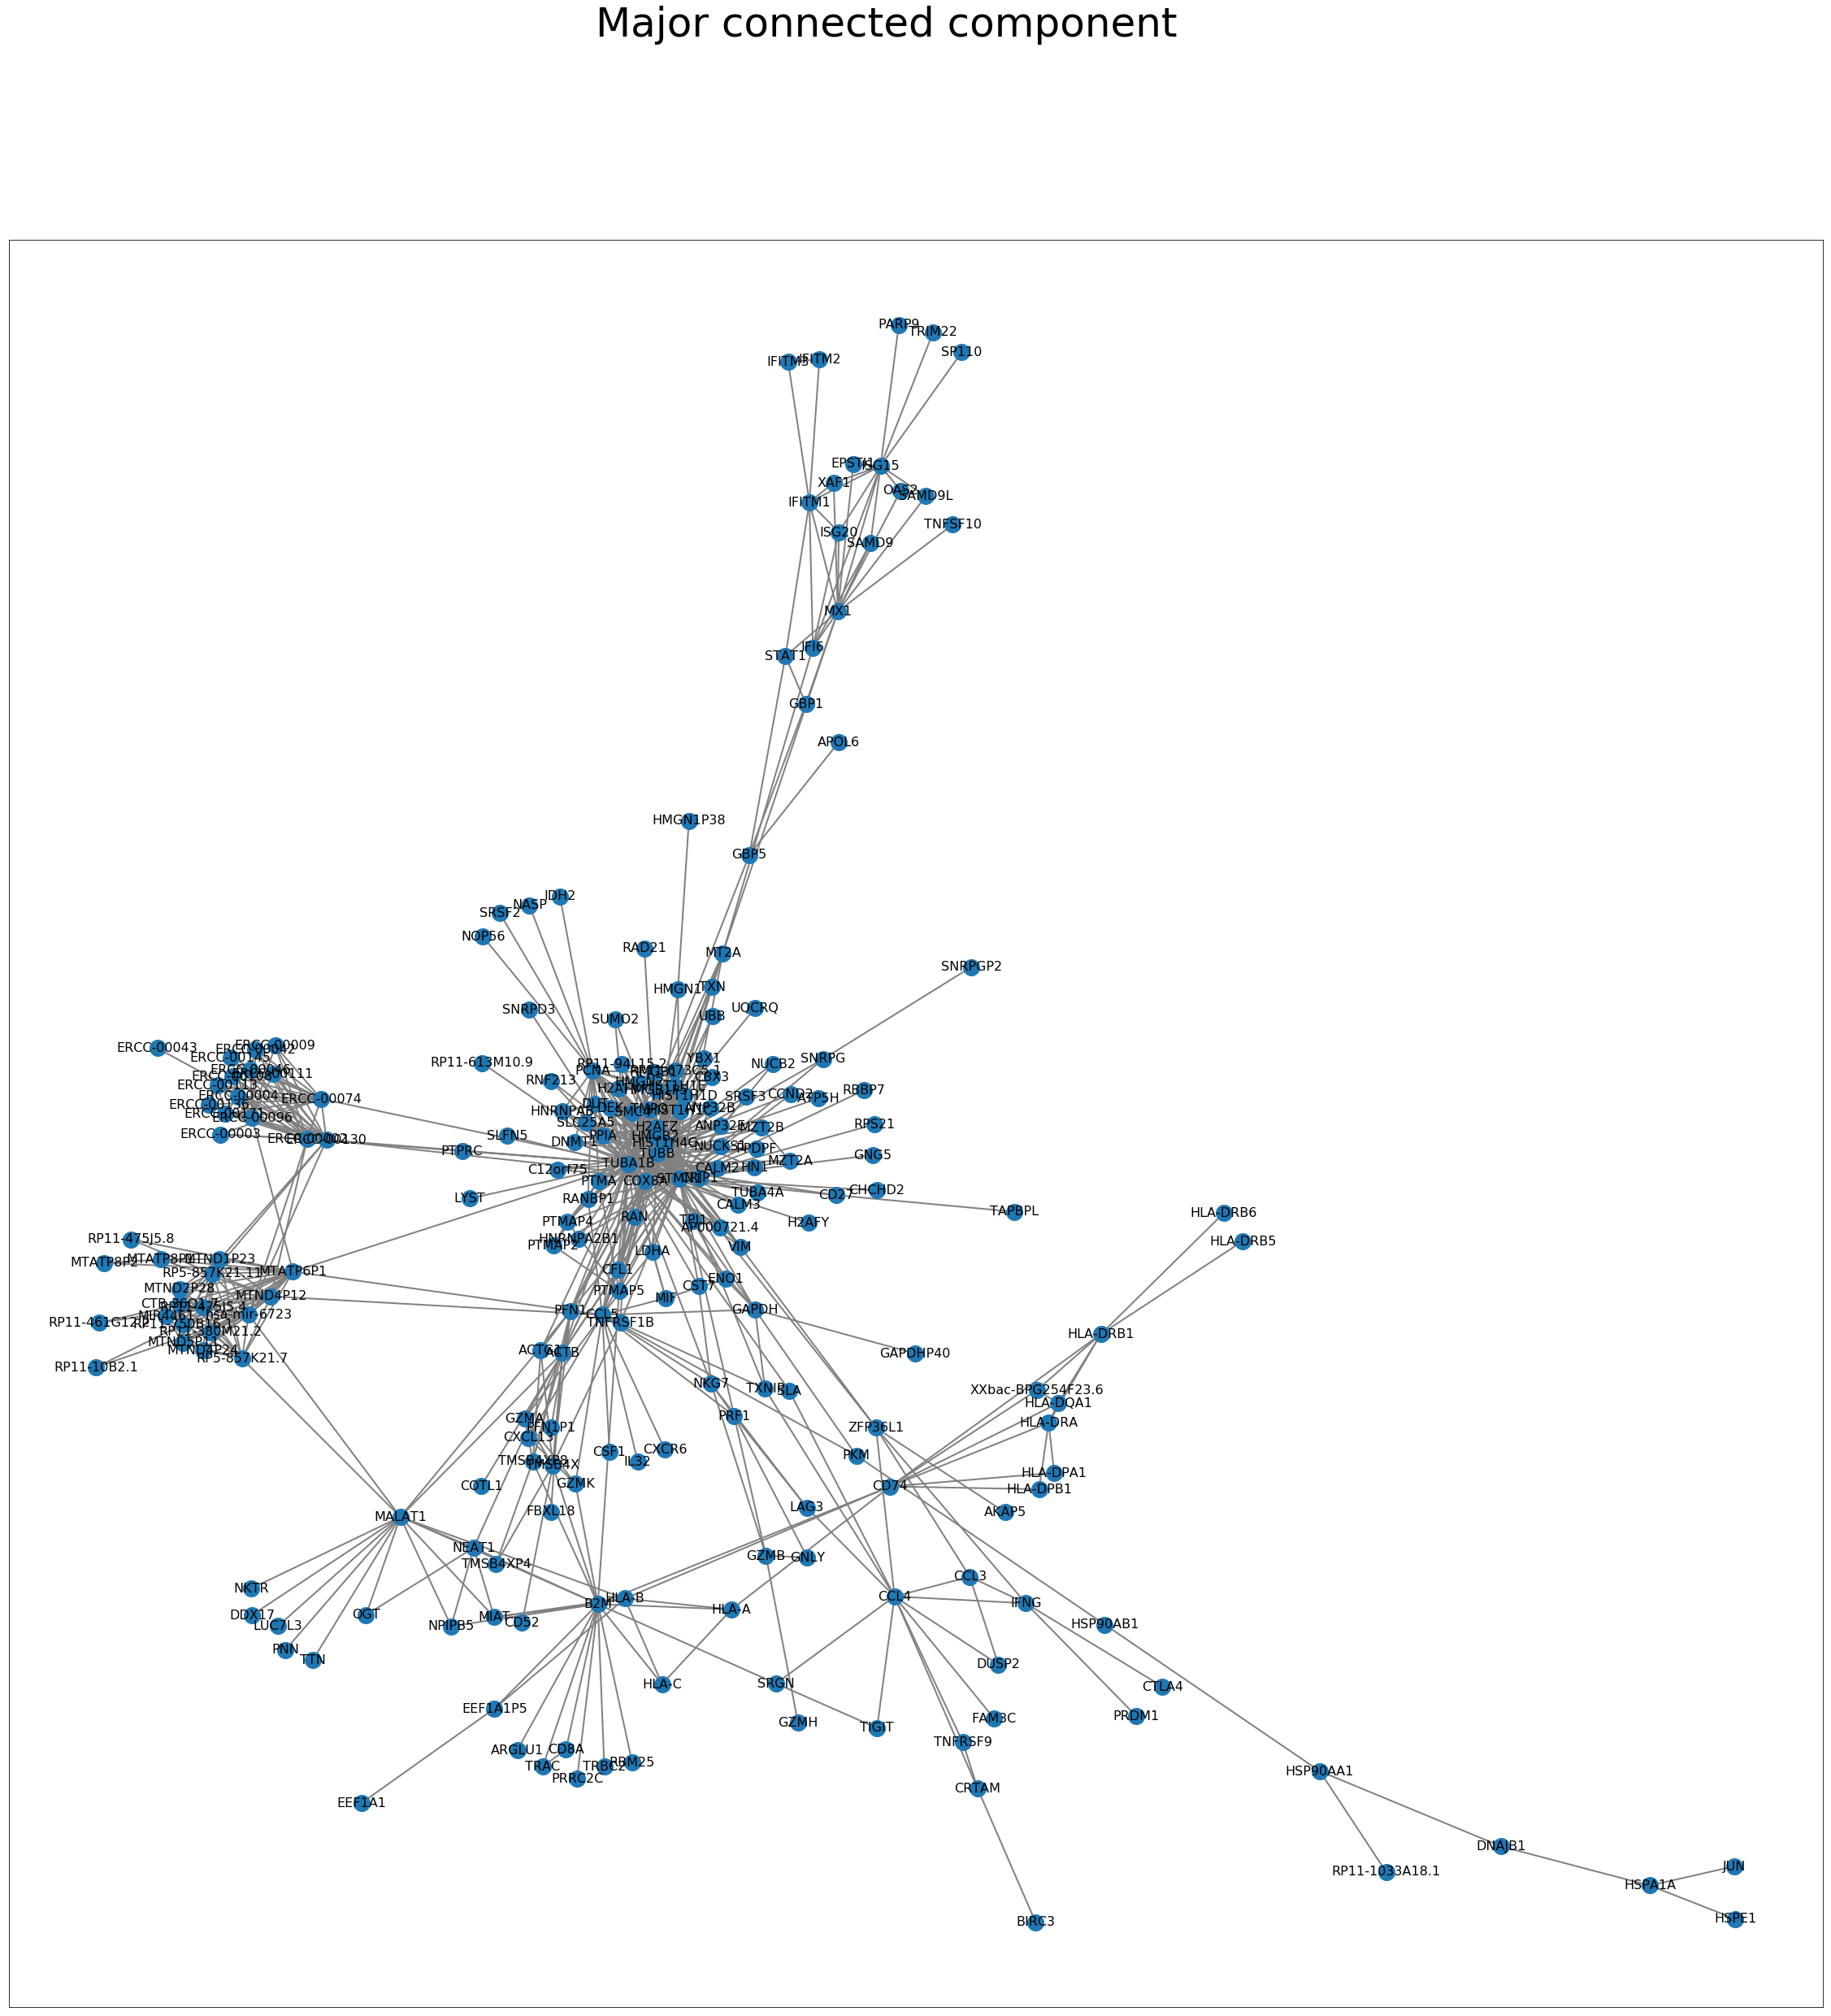

Co-expression with 3 GO covariates removed.
Number of nodes in full network: 480
Number of edges in full network: 987
Number of nodes in major connected component: 227
Number of edges in major connected component: 695


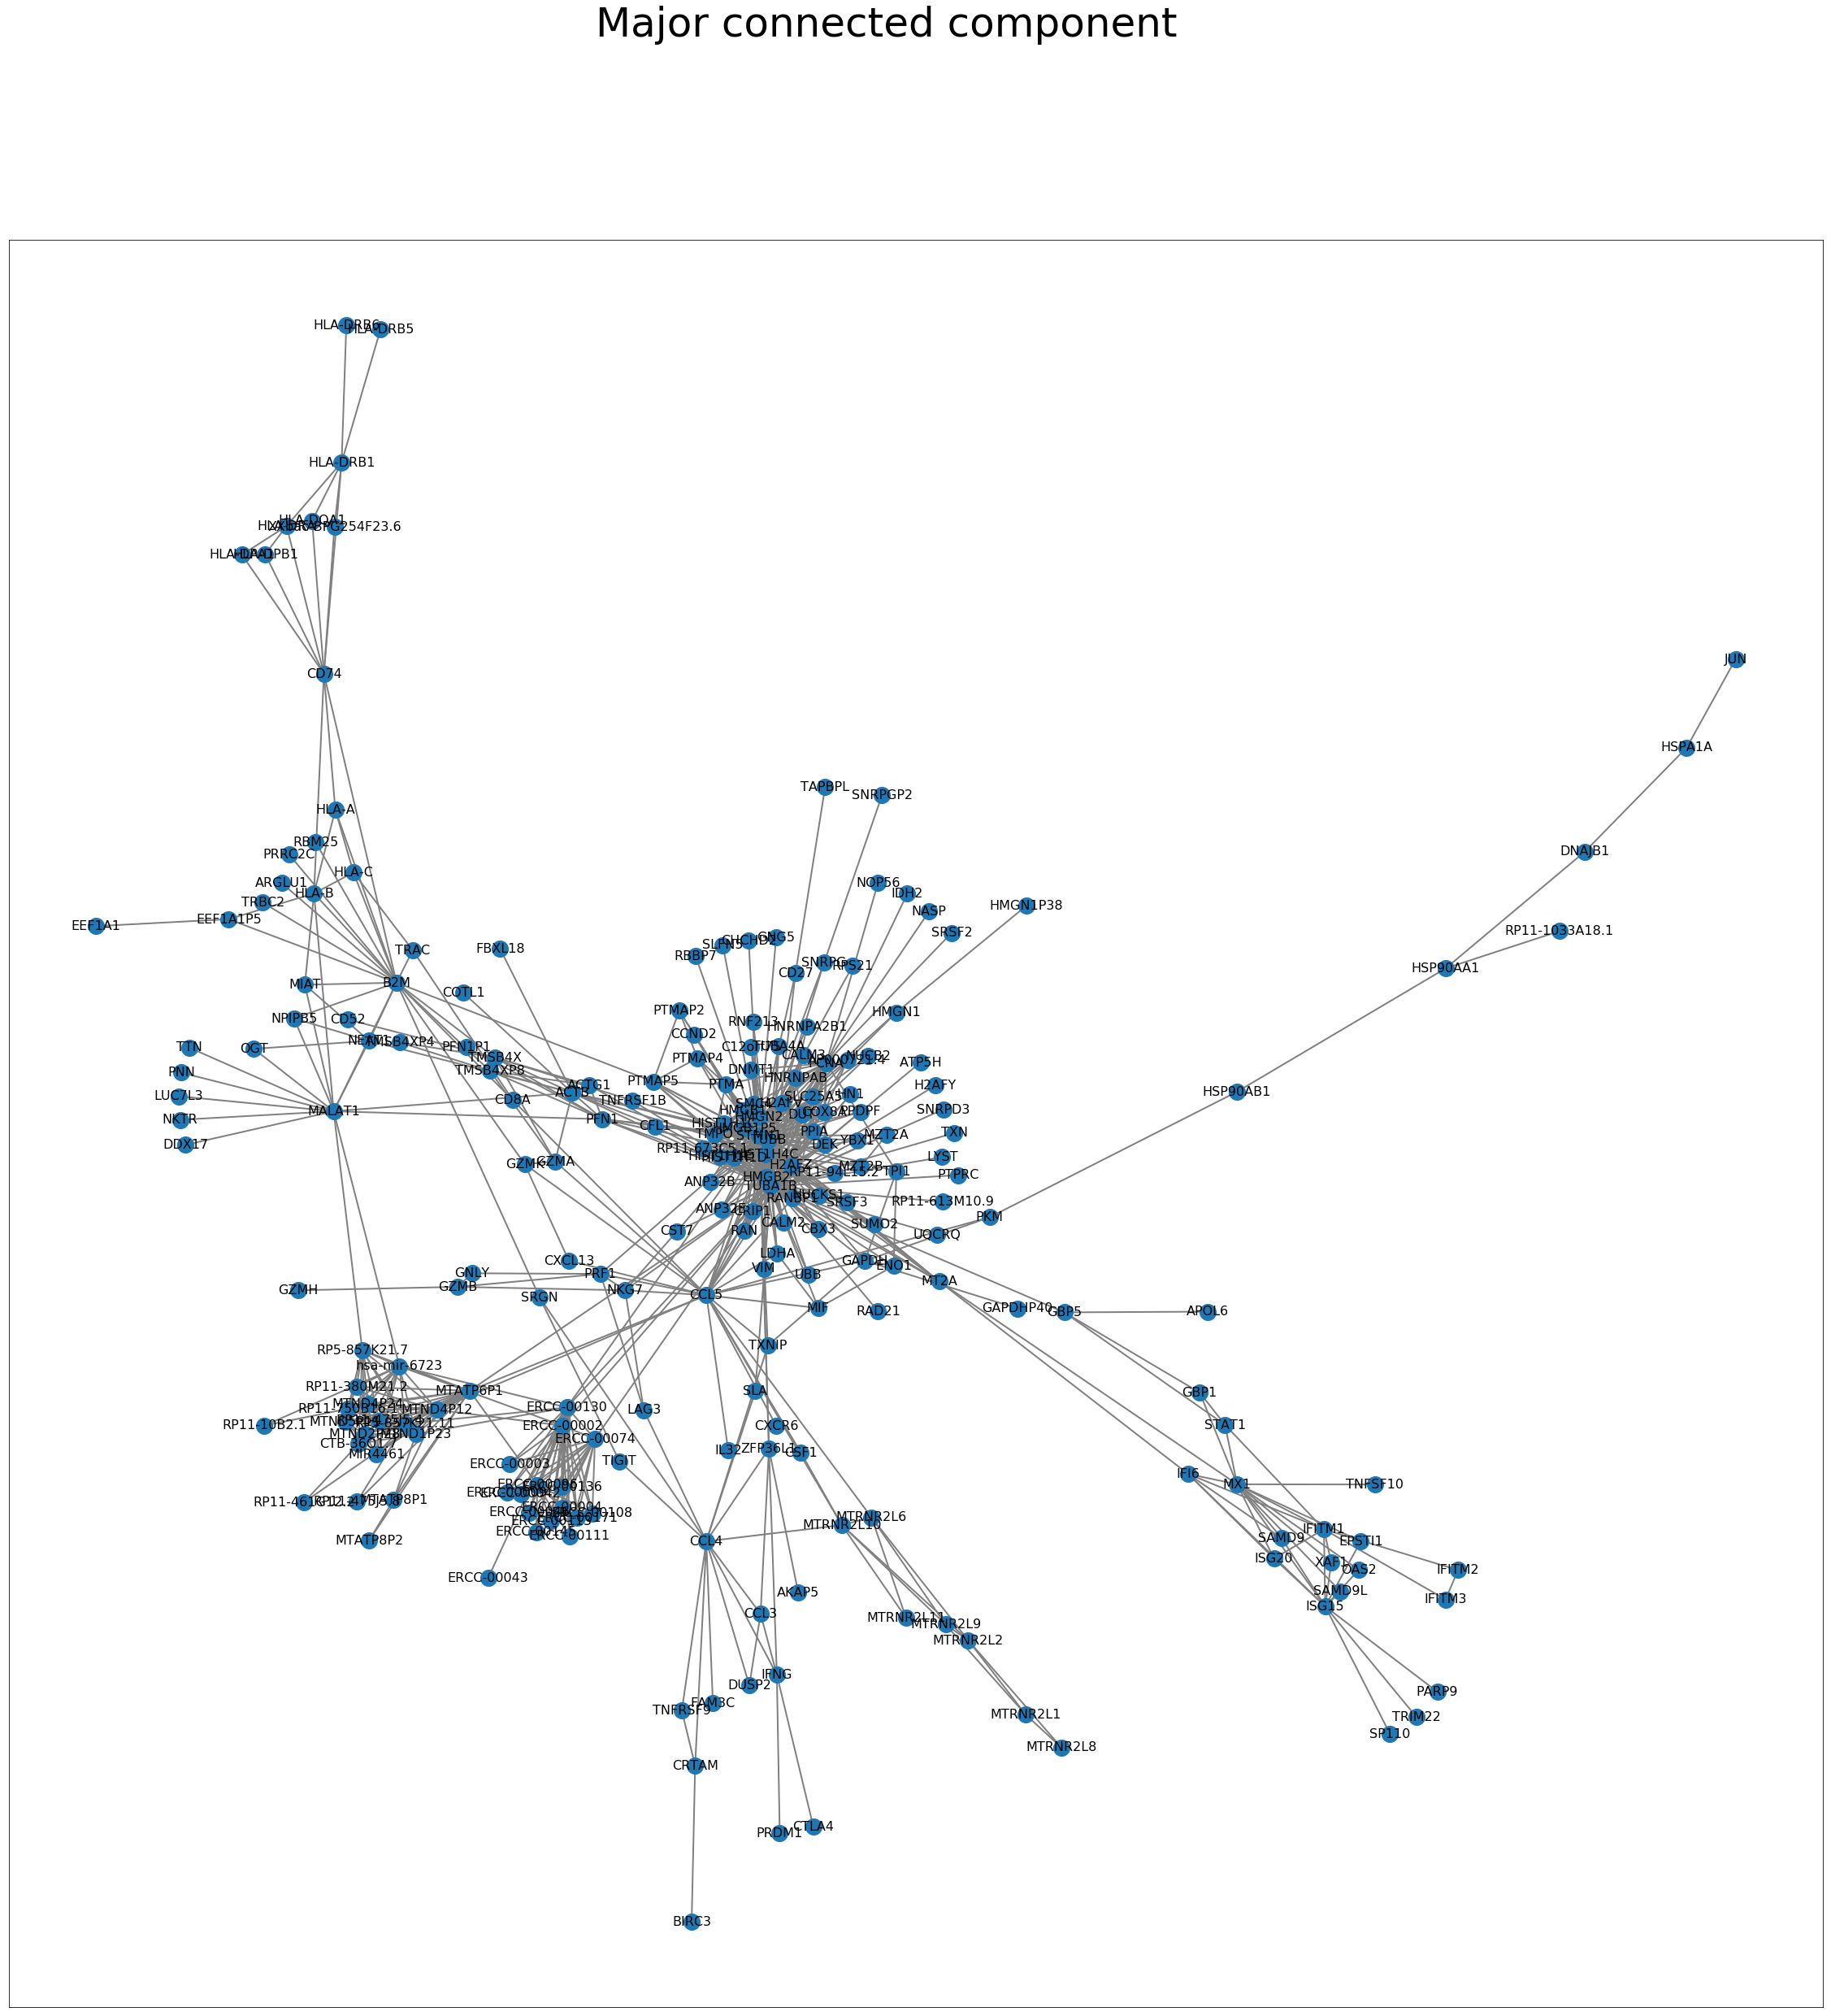

Co-expression with 4 GO covariates removed.
Number of nodes in full network: 480
Number of edges in full network: 998
Number of nodes in major connected component: 229
Number of edges in major connected component: 707


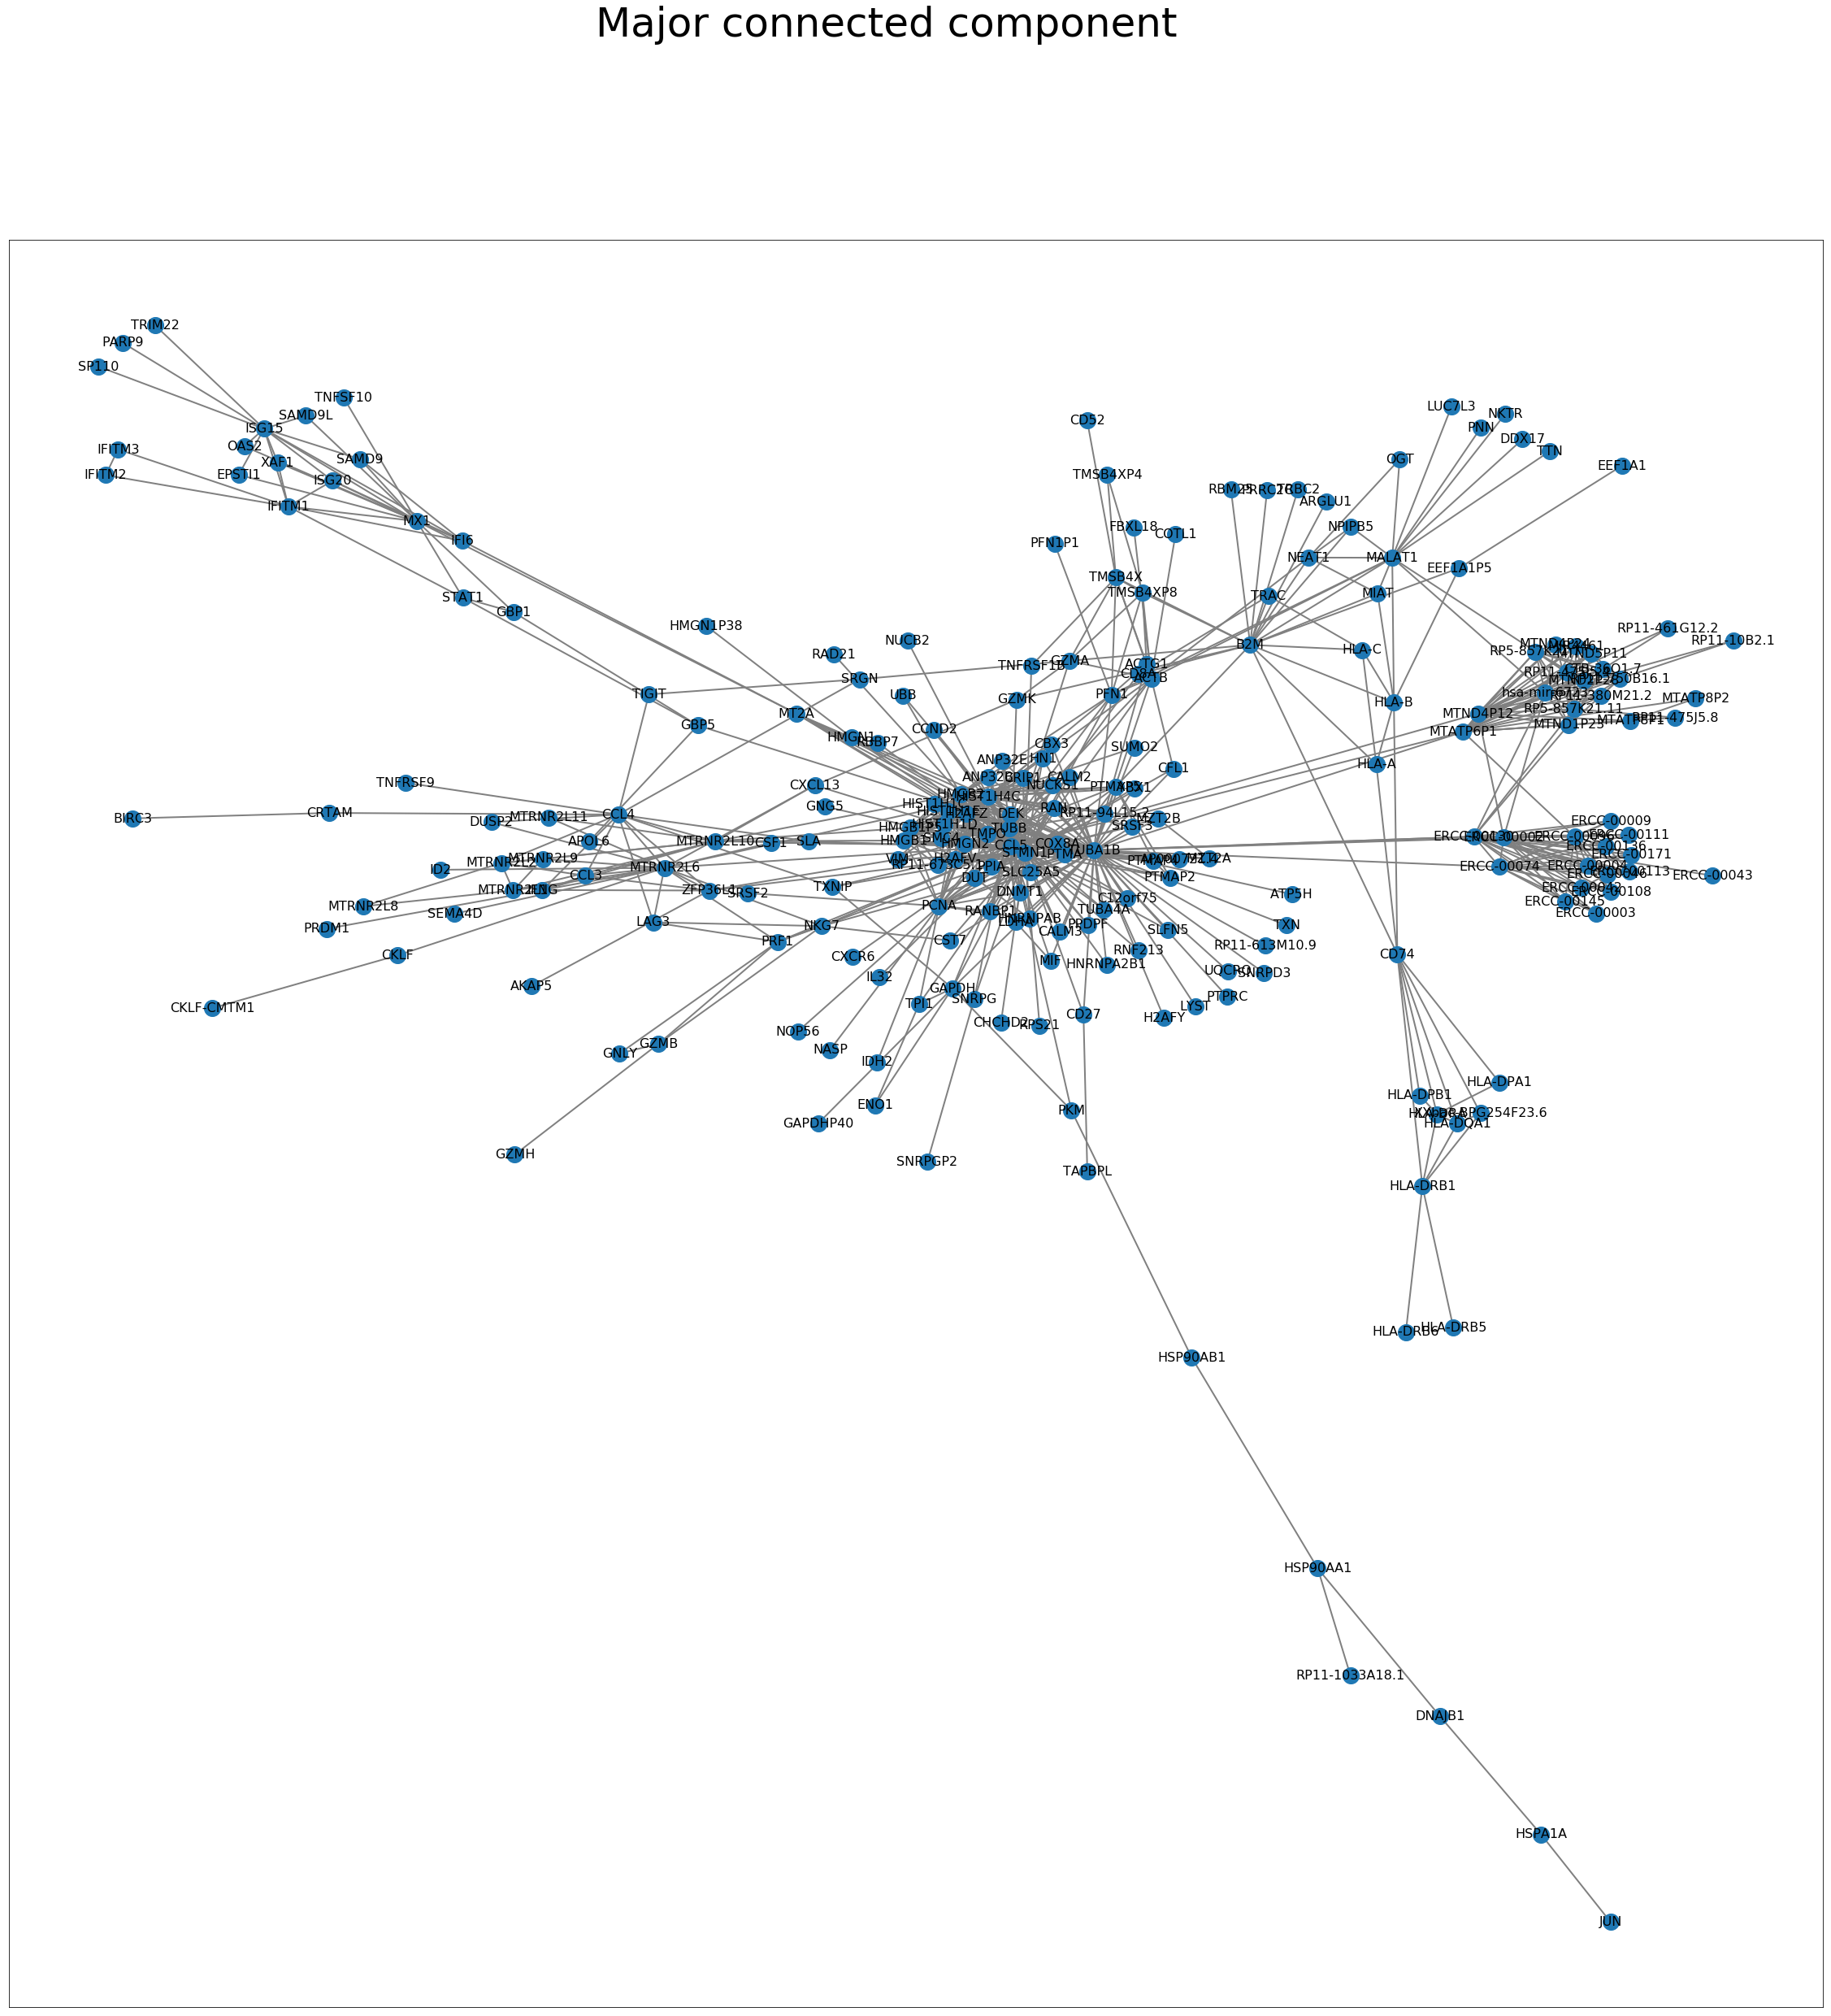

Co-expression with 5 GO covariates removed.
Number of nodes in full network: 474
Number of edges in full network: 971
Number of nodes in major connected component: 223
Number of edges in major connected component: 680


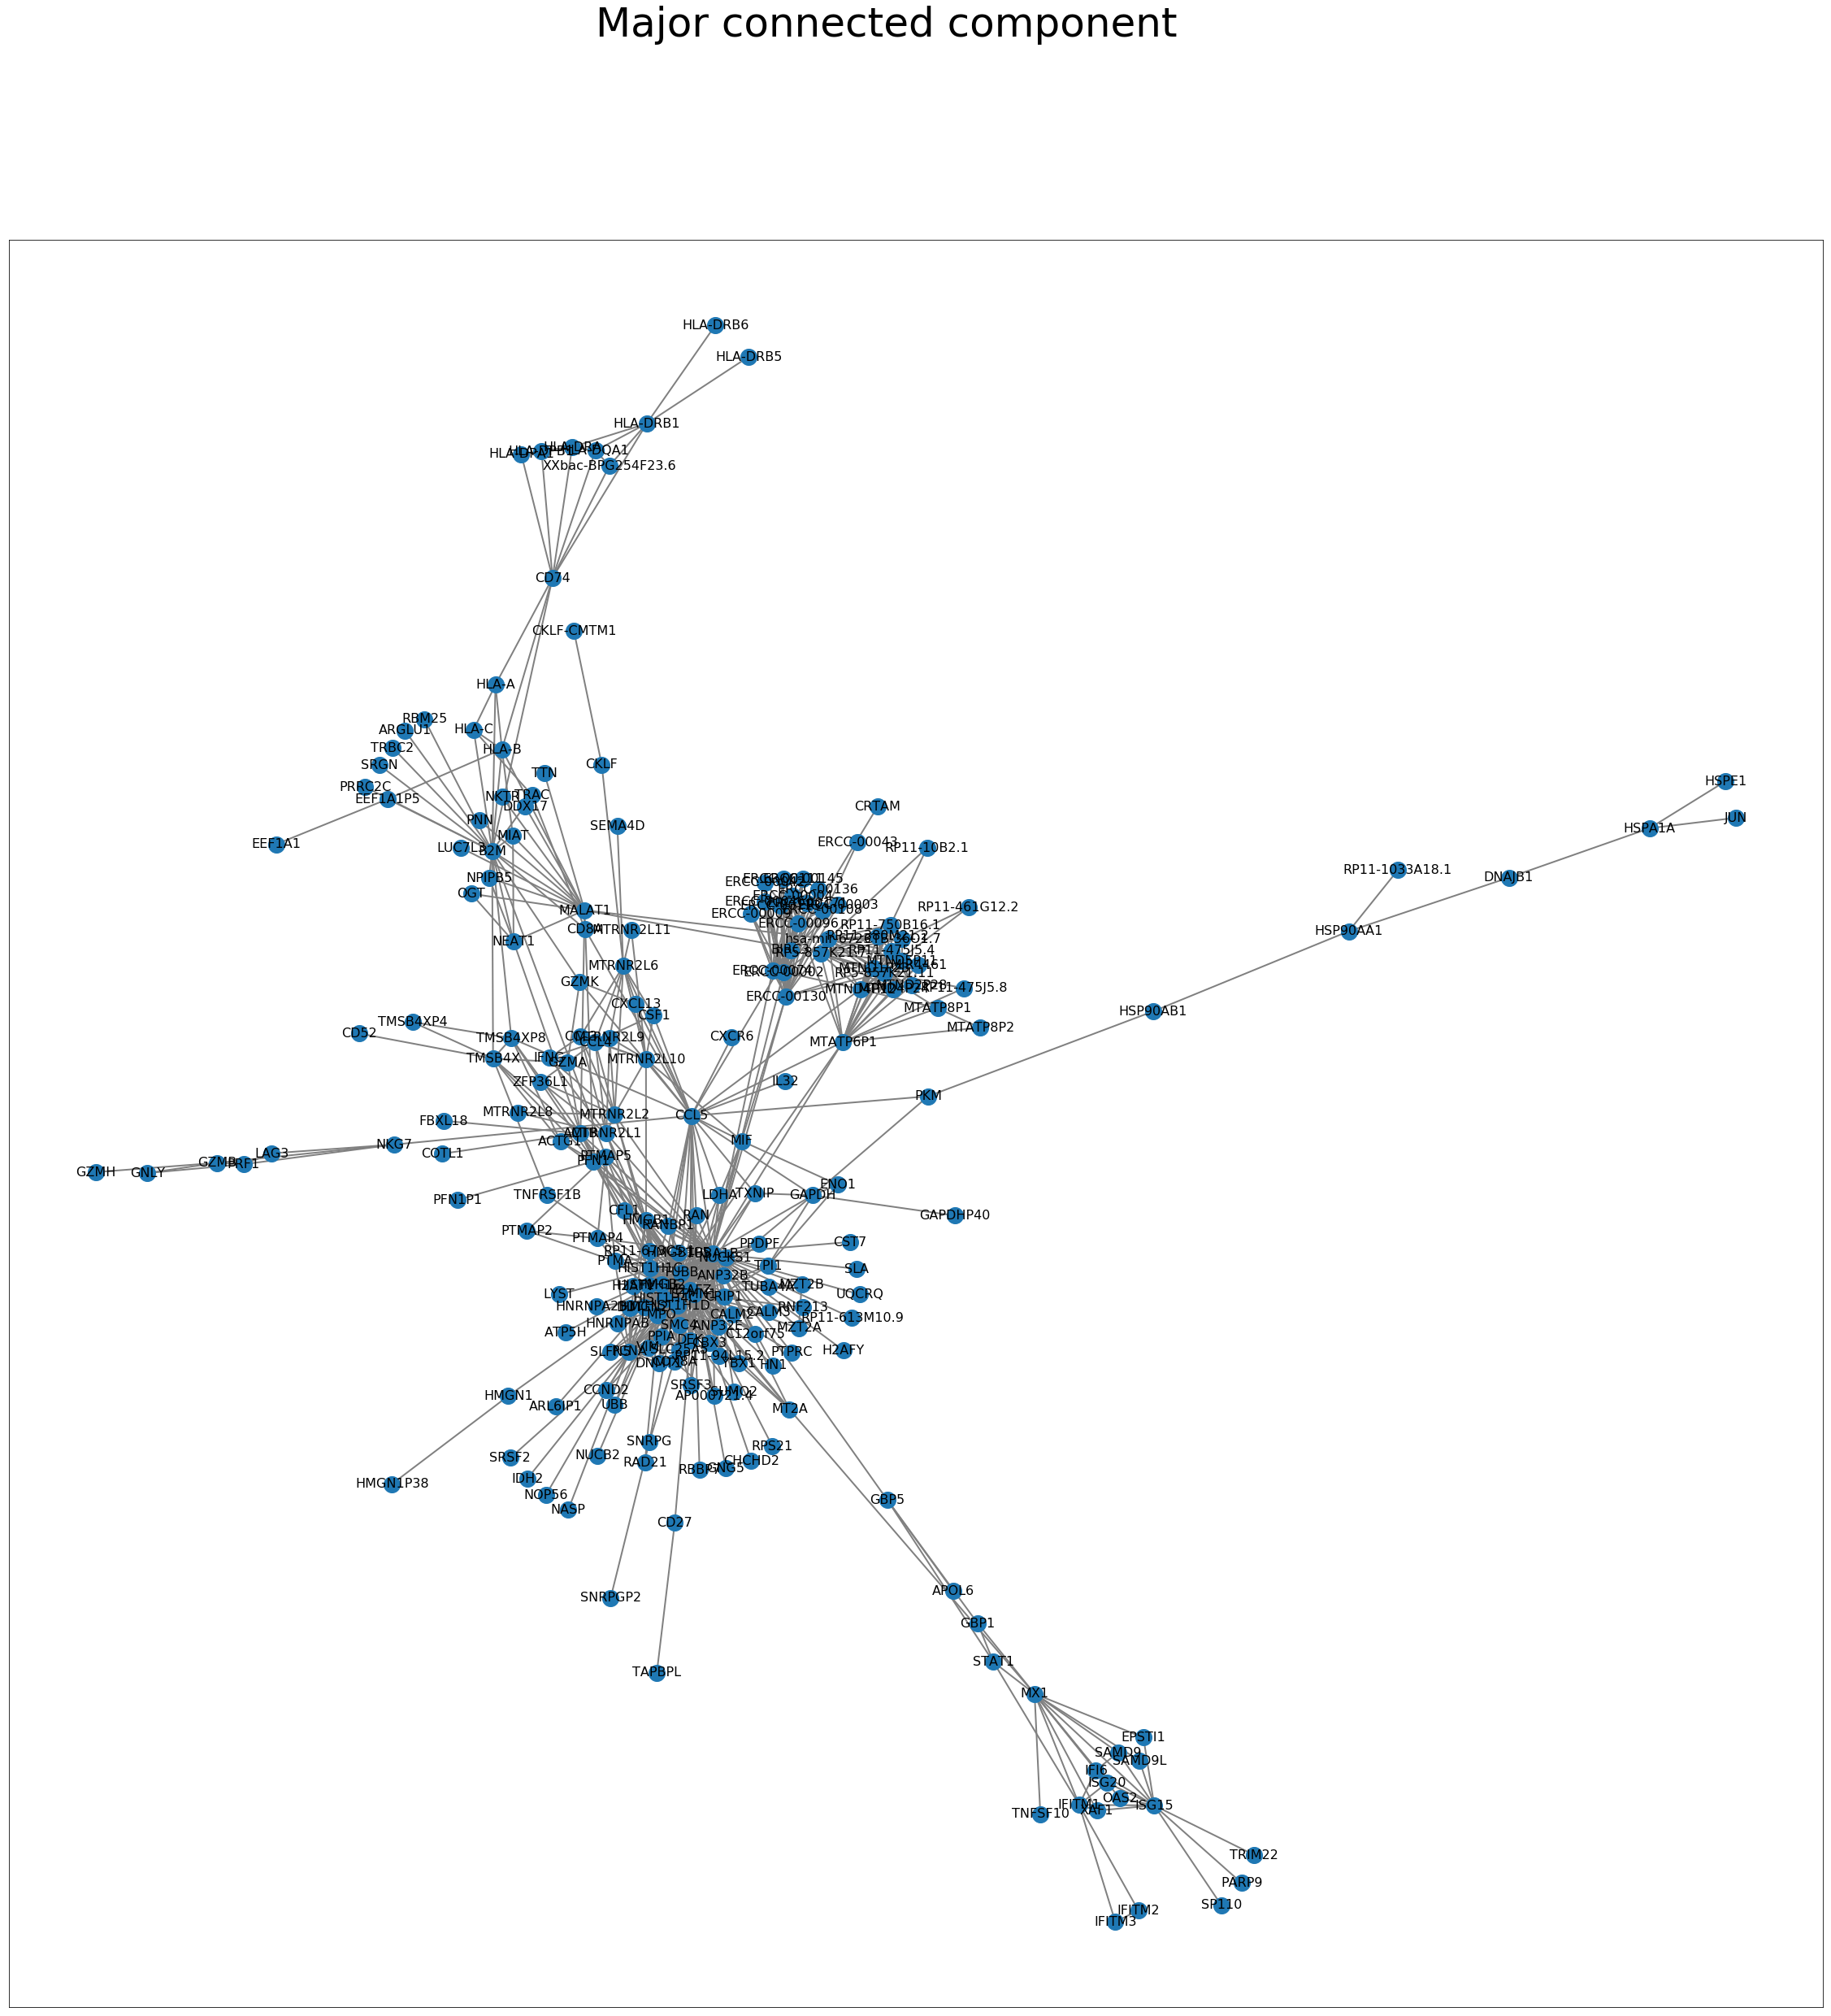

In [14]:
figscale=2
tdict=dict(zip(namet,range(len(namet))))
for xi in range(lvmax+1):
	print('Co-expression with {} GO covariates removed.'.format(xi))
	net=coex[xi][1]
	net|=net.T
	t1=net.any(axis=1)>0
	net=net[t1][:,t1]
	tnet=namet[t1]
	print('Number of nodes in full network: {}'.format(net.shape[0]))
	print('Number of edges in full network: {}'.format(net.sum()//2))
	#To major connected component
	t1=np.zeros_like(net)
	net2=net.copy()
	while (t1!=net2).any():
		t1=net2.copy()
		net2|=np.matmul(net2,net2)
	t1=net2.sum(axis=0)
	t1=t1==t1.max()
	net=net[t1][:,t1]
	tnet=tnet[t1]
	print('Number of nodes in major connected component: {}'.format(net.shape[0]))
	print('Number of edges in major connected component: {}'.format(net.sum()//2))
	#Draw here
	net2=pd.DataFrame(net,index=tnet,columns=tnet)
	net3=nx.to_networkx_graph(net2)
	f=plt.figure(figsize=(20*figscale,20*figscale))
	nx.draw_networkx(net3,node_size=200*figscale,font_size=8*figscale,width=1*figscale,edge_color=[0.5]*3);
	f.suptitle('Major connected component',fontsize=25*figscale);
	plt.show()
	#You can also output the network and draw in Cytoscape